In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.combine import SMOTEENN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from tqdm import tqdm_notebook
import pickle

import warnings
warnings.filterwarnings('ignore')

#Basic Operation

In [2]:
ddos_data=pd.read_csv('/content/DDos_final.csv')
ddos_data.head()

,Packet Length Std,Bwd Packet Length Mean,Bwd Packet Length Max,Average Packet Size,Packet Length Variance,Packet Length Mean,Max Packet Length,Bwd Packet Length Std,Avg Bwd Segment Size,Label
0,0.0,0.0,0,9.0,0.0,6.0,6,0.0,0.0,BENIGN
1,0.0,6.0,6,9.0,0.0,6.0,6,0.0,6.0,BENIGN
2,0.0,6.0,6,9.0,0.0,6.0,6,0.0,6.0,BENIGN
3,0.0,6.0,6,9.0,0.0,6.0,6,0.0,6.0,BENIGN
4,0.0,0.0,0,9.0,0.0,6.0,6,0.0,0.0,BENIGN


In [4]:
ddos_data.shape

(225745, 10)

In [5]:
class RemoveDuplicates:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates()

In [6]:
ddos_data.duplicated().sum()

np.int64(207677)

In [10]:
ddos_data=RemoveDuplicates().transform(ddos_data)

In [11]:
ddos_data.duplicated().sum()

np.int64(0)

In [12]:
ddos_data.shape

(18068, 10)

In [13]:
ddos_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18068 entries, 0 to 225737
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0    Packet Length Std       18068 non-null  float64
 1    Bwd Packet Length Mean  18068 non-null  float64
 2   Bwd Packet Length Max    18068 non-null  int64  
 3    Average Packet Size     18068 non-null  float64
 4    Packet Length Variance  18068 non-null  float64
 5    Packet Length Mean      18068 non-null  float64
 6    Max Packet Length       18068 non-null  int64  
 7    Bwd Packet Length Std   18068 non-null  float64
 8    Avg Bwd Segment Size    18068 non-null  float64
 9    Label                   18068 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 1.5+ MB


#Data Processing

In [14]:
def remove_outliers_IQR(col, df):


    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    iqr = Q3 - Q1

    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr

    df.loc[(df[col]>upper_limit),col] = upper_limit
    df.loc[(df[col]<lower_limit),col] = lower_limit

    return df


numeric_features=ddos_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numeric_features:
    ddos_data=remove_outliers_IQR(col, ddos_data)

In [16]:
X=ddos_data.drop(' Label', axis=1)
y=ddos_data[' Label']

In [17]:
X.head()

,Packet Length Std,Bwd Packet Length Mean,Bwd Packet Length Max,Average Packet Size,Packet Length Variance,Packet Length Mean,Max Packet Length,Bwd Packet Length Std,Avg Bwd Segment Size
0,0.000000,0.0,0,9.000000,0.000000,6.000000,6,0.0,0.0
1,0.000000,6.0,6,9.000000,0.000000,6.000000,6,0.0,6.0
9,14.433757,0.0,0,34.000000,208.333333,22.666667,31,0.0,0.0
13,12.500000,0.0,0,16.333333,156.250000,12.250000,31,0.0,0.0
14,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.0,0.0


In [19]:
y.value_counts()

,count
Label,
BENIGN,17639
DDoS,429


In [22]:
y=LabelEncoder().fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
numeric_features=X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_pipeline=Pipeline([
    ('cbrt', FunctionTransformer(np.cbrt, validate=True)),
    ('scaler', StandardScaler())
])

preprocessor=ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('cbrt',
                                                  FunctionTransformer(func=<ufunc 'cbrt'>,
                                                                      validate=True)),
                                                 ('scaler', StandardScaler())]),
                                 [' Packet Length Std',
                                  ' Bwd Packet Length Mean',
                                  'Bwd Packet Length Max',
                                  ' Average Packet Size',
                                  ' Packet Length Variance',
                                  ' Packet Length Mean', ' Max Packet Length',
                                  ' Bwd Packet Length Std',
                                  ' Avg Bwd Segment Size'])])

In [37]:
ddos_transformed=preprocessor.fit_transform(X)
ddos_transformed

array([[-2.46525111, -2.52905034, -2.14164557, ..., -1.93243581,
        -1.3372795 , -2.52905034],
       [-2.46525111, -1.83389606, -1.71904172, ..., -1.93243581,
        -1.3372795 , -1.83389606],
       [-1.56890073, -2.52905034, -2.14164557, ..., -1.62042628,
        -1.3372795 , -2.52905034],
       ...,
       [-0.74924197, -0.45654102, -0.57274353, ..., -0.771141  ,
        -0.17836252, -0.45654102],
       [ 1.06442009,  1.47455187,  1.13825484, ...,  0.96224178,
         1.21788002,  1.47455187],
       [-0.57086513, -2.52905034, -2.14164557, ..., -0.89231948,
        -1.3372795 , -2.52905034]])

In [38]:
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

In [28]:
smt = SMOTEENN()
X_resampled, y_resampled = smt.fit_resample(ddos_transformed, y)
X_resampled.shape, y_resampled.shape

((35169, 9), (35169,))

In [29]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

Original dataset shape Counter({np.int64(0): 17639, np.int64(1): 429})
Resampled dataset shape Counter({np.int64(1): 17594, np.int64(0): 17575})


In [30]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1 , precision, recall, roc_auc

In [31]:
def evaluate_models(X, y, models, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models_list = []
    accuracy_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    auc_list = []
    best_model = None
    best_score = 0

    for i in tqdm_notebook(range(len(list(models)))):
        model = list(models.values())[i]
        para = params[list(models.keys())[i]]

        gs = RandomizedSearchCV(model, para, cv=3, refit=True, verbose=2)
        gs.fit(X_train, y_train)

        best_params = gs.best_params_
        model.set_params(**best_params)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)

        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)

        models_list.append(list(models.keys())[i])
        accuracy_list.append(model_test_accuracy)
        f1_list.append(model_test_f1)
        precision_list.append(model_test_precision)
        recall_list.append(model_test_recall)
        auc_list.append(model_test_rocauc_score)

        print(f"Model: {list(models.keys())[i]}")
        print("Model performance for Training set")
        print(f"- Accuracy: {model_train_accuracy:.4f}")
        print(f"- F1 score: {model_train_f1:.4f}")
        print(f"- Precision: {model_train_precision:.4f}")
        print(f"- Recall: {model_train_recall:.4f}")
        print(f"- ROC AUC Score: {model_train_rocauc_score:.4f}")
        print("----------------------------------")
        print("Model performance for Test set")
        print(f"- Accuracy: {model_test_accuracy:.4f}")
        print(f"- F1 score: {model_test_f1:.4f}")
        print(f"- Precision: {model_test_precision:.4f}")
        print(f"- Recall: {model_test_recall:.4f}")
        print(f"- ROC AUC Score: {model_test_rocauc_score:.4f}")
        print("=" * 35)
        print("\n")

        if model_test_rocauc_score > best_score:
            best_score = model_test_rocauc_score
            best_model = model
    if best_model is not None:
        with open("best_model.pkl", "wb") as f:
            pickle.dump(best_model, f)
        print(f"Best model saved to 'best_model.pkl' with ROC AUC Score: {best_score:.4f}")

    report = pd.DataFrame(
        list(zip(models_list, accuracy_list, f1_list, precision_list, recall_list, auc_list)),
        columns=['Model Name', 'Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC Score']
    ).sort_values(by=['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC Score'], ascending=False)

    return report

In [32]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LGBMClassifier': LGBMClassifier()
}

param_grids = {
    'LogisticRegression': {
        "class_weight":["balanced"],
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2]
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 63]
    }
}

In [33]:
report = evaluate_models(X_resampled, y_resampled, models, param_grids)

  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.6s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total

In [34]:
report

,Model Name,Accuracy,F1 Score,Precision,Recall,ROC AUC Score
2,DecisionTreeClassifier,0.999431,0.999433,0.999149,0.999716,0.999431
1,RandomForestClassifier,0.999147,0.999149,0.998583,0.999716,0.999146
3,LGBMClassifier,0.998721,0.998725,0.997453,1.000000,0.998718
0,LogisticRegression,0.915695,0.918263,0.892790,0.945233,0.915636


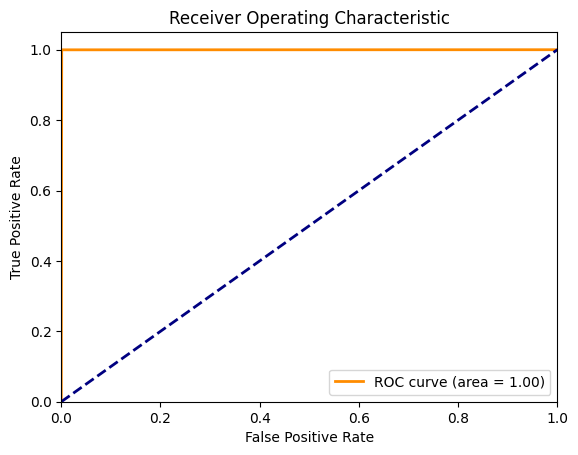

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

y_pred_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [39]:
ddos_data.columns

Index([' Packet Length Std', ' Bwd Packet Length Mean',
       'Bwd Packet Length Max', ' Average Packet Size',
       ' Packet Length Variance', ' Packet Length Mean', ' Max Packet Length',
       ' Bwd Packet Length Std', ' Avg Bwd Segment Size', ' Label'],
      dtype='object')

In [41]:
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

with open('/content/preprocessor.pkl', 'rb') as f:
    preprocess = pickle.load(f)


input_data = (1723.622534,1934.5,5840,833.5,2970874.638,777.9333333,5840,2375.523332,1934.5)

input_df = pd.DataFrame([input_data], columns=[' Packet Length Std', ' Bwd Packet Length Mean',
       'Bwd Packet Length Max', ' Average Packet Size',
       ' Packet Length Variance', ' Packet Length Mean', ' Max Packet Length',
       ' Bwd Packet Length Std', ' Avg Bwd Segment Size'])

input_data_std = preprocess.transform(input_df)

prediction = best_model.predict(input_data_std)
print(prediction)

if(prediction[0] == 0):
  print('BENIGN')

else:
  print('DDoS Attack')

[1]
DDoS Attack
